In [1]:
%%time
%matplotlib inline
from new_import import *

CPU times: user 13.6 s, sys: 4.23 s, total: 17.8 s
Wall time: 11.7 s


In [2]:
%%time
# Dask gateway
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,4))
dc = datacube.Datacube()

# Configure s3 access
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

client

Starting new cluster.
CPU times: user 824 ms, sys: 44.1 ms, total: 868 ms
Wall time: 9.39 s


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.7c9feb13b5174e6e84b04907443ea6d6/status,


In [3]:
## cấu hình thời gian lấy ảnh và tọa độ
date_range = ('2022-09-01', '2023-10-01')
longtitude_range = (105.86575, 105.94120)
latitude_range = (9.65070, 9.69850)

In [4]:
## truy vấn ảnh vệ tinh sen2
data = load_data(dc, date_range, longtitude_range, latitude_range)
notebook_utils.heading(notebook_utils.xarray_object_size(data))
display(data)

Most common native CRS: EPSG:32648
No datasets require offset correction
The valid_data_mask and scale (no offset) have been applied to the reflectance bands


<xarray.Dataset>
Dimensions:      (time: 78, y: 532, x: 830)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:38.706000 ... 2023-09...
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648
Data variables:
    blue         (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 532, 830), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [5]:
%%time
# Tiến hành loại bỏ các vị trí bị mây ảnh hưởng
result = mask_clean(data)
progress(result)

,bits,values,description
qa,"[0, 1, 2, 3, 4, 5, 6, 7]","{'0': 'no data', '1': 'saturated or defective'...",Sen2Cor Scene Classification


{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

CPU times: user 114 ms, sys: 7.17 ms, total: 122 ms
Wall time: 118 ms


VBox()

In [6]:
# Tiến hành tính toán NDVI
ds1 = calculate_indices(result, index='NDVI', satellite_mission='s2')
ndvi = ds1["NDVI"]
display(ndvi)

<xarray.DataArray 'NDVI' (time: 78, y: 532, x: 830)>
dask.array<truediv, shape=(78, 532, 830), dtype=float32, chunksize=(1, 532, 830), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:38.706000 ... 2023-09...
  * y            (y) float64 1.072e+06 1.072e+06 ... 1.067e+06 1.067e+06
  * x            (x) float64 5.95e+05 5.95e+05 5.95e+05 ... 6.033e+05 6.033e+05
    spatial_ref  int32 32648

In [17]:
%%time
## tính ndvi theo tháng
average_ndvi = ndvi.resample(time='1M').mean().persist()
progress(average_ndvi)

CPU times: user 49.3 ms, sys: 3.67 ms, total: 53 ms
Wall time: 50.8 ms


VBox()

In [18]:
# compute average_ndvi
average_ndvi = average_ndvi.compute()

In [9]:
# cấu hình vh vv file
name_vh = "ThuanHoa/ThuanHoa_VH.tif"
name_vv = "ThuanHoa/ThuanHoa_VV.tif"

# load dữ liệu sen1
dsvh, dsvv = load_sen1(name_vh, name_vv)

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


In [11]:
mask = ~np.isnan(average_ndvi)
X_train = np.stack([dsvh.values[mask], dsvv.values[mask]], axis=1)
y_train = average_ndvi.values[mask]

In [12]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [13]:
X_pred = np.stack([dsvh.values[~mask], dsvv.values[~mask]], axis=1)
average_ndvi.values[~mask] = model.predict(X_pred)

In [14]:
average_ndvi_filled = xr.DataArray(average_ndvi, dims=average_ndvi.dims)

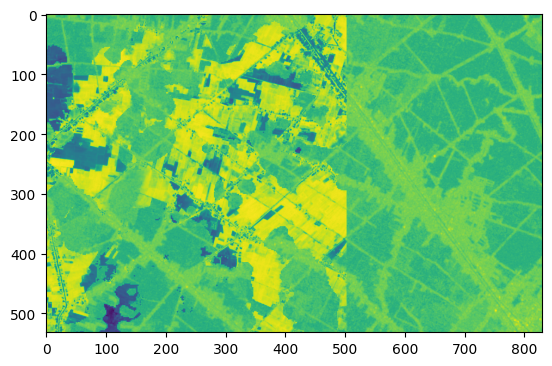

In [16]:
plt.imshow(average_ndvi_filled.isel(time=1))

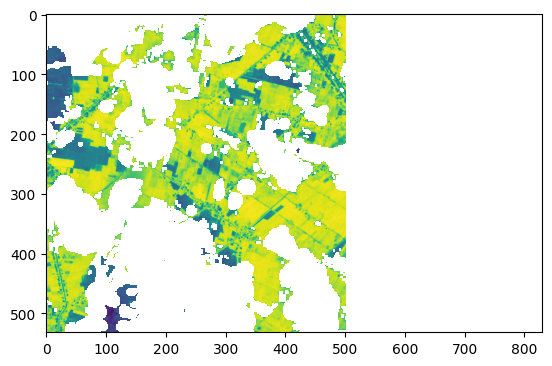

In [19]:
plt.imshow(average_ndvi.isel(time=1))